In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

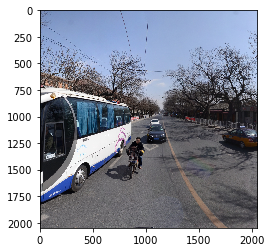

In [61]:
testimg = mpimg.imread("/scratch/lt2326-h21/a1/images/0000486.jpg")
%matplotlib inline
plt.imshow(testimg)

In [9]:
import jsonlines
source_dir = "/scratch/lt2326-h21/a1/"
image_dir = "/scratch/lt2326-h21/a1/images/"
info_filename = "/scratch/lt2326-h21/a1/info.json"

In [10]:
from os import listdir
from os.path import isfile, join
image_files = [f for f in listdir(image_dir) if isfile(join(image_dir, f))]

In [37]:
len(image_files)

1000

In [11]:
import json
with open(info_filename, 'r') as info_file:
    data = info_file.read()

In [12]:
obj = json.loads(data)

In [18]:
obj.keys()

dict_keys(['test_cls', 'test_det', 'train', 'val'])

In [31]:
print("test_cls", len(obj['test_cls']), obj['test_cls'][0].keys())
print("test_det", len(obj['test_det']), obj['test_det'][0].keys())
print("train", len(obj['train']), obj['train'][0].keys())
print("val", len(obj['val']), obj['val'][0].keys())

test_cls 3269 dict_keys(['file_name', 'height', 'image_id', 'width'])
test_det 3129 dict_keys(['file_name', 'height', 'image_id', 'width'])
train 24290 dict_keys(['file_name', 'height', 'image_id', 'width'])
val 1597 dict_keys(['file_name', 'height', 'image_id', 'width'])


In [34]:
import pandas as pd

df_test_cls = pd.DataFrame.from_dict(obj['test_cls'])
df_test_det = pd.DataFrame.from_dict(obj['test_det'])
df_train = pd.DataFrame.from_dict(obj['train'])
df_val = pd.DataFrame.from_dict(obj['val'])

In [36]:
df_val

,file_name,height,image_id,width
0,0000486.jpg,2048,0000486,2048
1,0000487.jpg,2048,0000487,2048
2,0000488.jpg,2048,0000488,2048
3,0000489.jpg,2048,0000489,2048
4,0000494.jpg,2048,0000494,2048
...,...,...,...,...
1592,3045634.jpg,2048,3045634,2048
1593,3045635.jpg,2048,3045635,2048
1594,3045636.jpg,2048,3045636,2048
1595,3045637.jpg,2048,3045637,2048


In [52]:
with jsonlines.open(source_dir + "val.jsonl") as reader:
   line1 = reader.read()
   print(type(line1))
   key_list = list(line1.keys())
   print(key_list)
   print("file_name:", line1['file_name'])
   print("image_id:", line1['image_id'])
   annotations = line1['annotations']
   for item in annotations:
      print("  ", len(item))
      for temp in item:
         print("    ", list(temp.keys()))
         print("    ", temp['adjusted_bbox'])
         print("     is_chinese:", temp['is_chinese'])

<class 'dict'>
['annotations', 'file_name', 'height', 'ignore', 'image_id', 'width']
file_name: 0000486.jpg
image_id: 0000486
   4
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [398.7268146435821, 1211.6231527508403, 14.957597548258718, 29.099630908325935]
     is_chinese: True
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [413.6844121918408, 1206.3100292974048, 17.094397198009915, 28.869673184175554]
     is_chinese: True
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [430.7788093898507, 1201.5051176525587, 13.675517758407977, 28.030720357297696]
     is_chinese: True
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [444.4543271482587, 1196.422999566664, 16.667037268059687, 27.92249879508927]
     is_chinese: True
   5
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [85.55367450784708, 1724.1485678038825, 30.24624856338029, 32.10458436403451]
     

In [60]:
with jsonlines.open(source_dir + "test_cls.jsonl") as reader:
   line1 = reader.read()
   key_list = list(line1.keys())
   print(key_list)
   print("file_name:", line1['file_name'])
   print("image_id:", line1['image_id'])
   proposals = line1['proposals']
   for item in proposals:
      print("    ", list(item.keys()))
      print("    ", item['adjusted_bbox'])
      print("    ", item['polygon'])

['file_name', 'height', 'image_id', 'proposals', 'width']
file_name: 0000001.jpg
image_id: 0000001
     ['adjusted_bbox', 'polygon']
     [1492.8684112354124, 1020.9181839073769, 23.764909585513124, 32.58313861351917]
     [[1492.8684112354124, 1021.9183905397639], [1516.6333208209255, 1020.4180805911835], [1516.6333208209255, 1052.6299425027605], [1492.8684112354124, 1053.9370125299638]]
     ['adjusted_bbox', 'polygon']
     [1546.4474801191147, 1017.7175226837388, 19.44401693360146, 32.91616741383871]
     [[1546.4474801191147, 1018.5358735647826], [1565.8914970527162, 1017.3083472432169], [1565.8914970527162, 1049.9207428100121], [1546.4474801191147, 1050.9901637413602]]
     ['adjusted_bbox', 'polygon']
     [1600.0265490028169, 1014.3168201336233, 19.87610619879274, 33.36209953882201]
     [[1600.0265490028169, 1015.1533565898014], [1619.9026552016096, 1013.8985519055342], [1619.9026552016096, 1046.950129111823], [1600.0265490028169, 1048.0433149527564]]
     ['adjusted_bbox', 'p

In [51]:
with jsonlines.open(source_dir + "train.jsonl") as reader:
   line1 = reader.read()
   key_list = list(line1.keys())
   print(key_list)
   print("file_name:", line1['file_name'])
   print("image_id:", line1['image_id'])
   annotations = line1['annotations']
   for item in annotations:
      print("  ", len(item))
      for temp in item:
         print("    ", list(temp.keys()))
         print("    ", temp['adjusted_bbox'])
         print("     is_chinese:", temp['is_chinese'])


['annotations', 'file_name', 'height', 'ignore', 'image_id', 'width']
file_name: 0000172.jpg
image_id: 0000172
   4
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [140.26028096262758, 897.1957001682758, 22.167573140645146, 38.36424196832945]
     is_chinese: True
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [162.42785410327272, 898.5416545674744, 23.376713493771263, 37.74268246537315]
     is_chinese: True
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [185.80456759704398, 899.90363223333, 21.764526356269812, 37.08391855844286]
     is_chinese: True
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [207.5690939533138, 901.1694702992428, 20.152339218768304, 36.47045952189433]
     is_chinese: True
   6
     ['adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text']
     [235.37932207521408, 904.5575704933226, 18.943198865642216, 25.895454849918906]
     is_chinese: True
 